In [4]:
import torch 
from scripts.sample_diffusion import *
import argparse, os, sys, glob, datetime, yaml
from omegaconf import OmegaConf
import torchvision
import PIL
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from ldm_testing import *
from jscc_baseline_testing import deep_jscc_testing

In [5]:
!nvidia-smi

Sun Jul  9 11:25:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                      On | 00000000:1F:00.0 Off |                    0 |
|  0%   26C    P8               21W / 300W|      0MiB / 46068MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [49]:
image_path = "images/bedrooms/resized.png"
test_snr = 20
LOGDIR = "models/ldm/lsun_beds256"
checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
config = OmegaConf.load(os.path.join(LOGDIR, "config.yaml"))
save_image_path = f"images/bedrooms/ldm_testing_{test_snr}.png"

In [7]:
model, _ = load_model(config, checkpoint_path, gpu = True, eval_mode = True)

Loading model from models/ldm/lsun_beds256/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.


In [50]:
scale_function = lambda img: (2*img - 1.0)
ScaleShiftTransform = torchvision.transforms.Lambda(scale_function)
data_transform = Compose(
        [
            Resize(size = (256, 256)),
            ToTensor(),
            ScaleShiftTransform
        ]
    )

In [51]:
image = Image.open(image_path)
image = data_transform(image)[None].cuda()
image.shape

torch.Size([1, 3, 256, 256])

In [52]:
reconstructed_image = encode_through_channel(model, image, test_snr, denoise_latent=True, verbose=True)

Progressive Generation: 100%|██████████| 5/5 [00:00<00:00, 18.00it/s]


In [53]:
recon_image = custom_to_pil(reconstructed_image[0])
recon_image.save(save_image_path)

In [54]:
psnr(image, reconstructed_image)

tensor(27.9830, device='cuda:0')

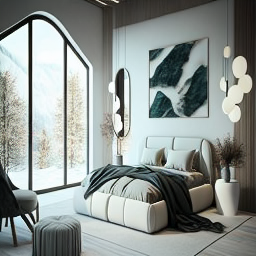

In [55]:
recon_image